# Does Clinton have a 97% chance of winning? 

## Biases (or inefficiencies) in election prediction markets

PredictIt has several prediction markets [for the general election](https://www.predictit.org/Browse/Group/67/National). However, PredictIt also has a market for the election outcome in every state.

If we took each state's prediction market, and used it to simulate general election, what would we find? If the market is roughly efficient, we would expect the mean of simulated election outcomes to be about the same as the national election markets. Surprisingly, **I find this technique yields a 97% chance of a Clinton win**. This estimate is significantly higher than the PredictIt general election market, and higher than Rothchild's [debiased aggregate](http://predictwise.com/). 

So, are the general markets not bullish enough on Clinton, or are the state markets too bullish on Clinton? Unfortunately, I suspect the latter. A few states -- specifically, Georgia, Alaska, Arizona and Montana --  may have overpriced Clinton shares. 

Of course, I am *not* a trained economist, statistician or politican scientist. This work also suffers from a serious limitation: no access to historical trade data. If you have notes on this, or access to historical data from a prediction market, please contact me:

`ffff [at] berkeley [] edu`

## Simulating the election with market-derived probabilities

First, we'll get a prediction market from each state on PredictIt. 

PredictIt has a Republican and Democratic market for each state election, with each market having its own yes/no. The odds on an outcome may be slightly different between markets (more on this below). 

In [1]:
!pip install requests
%pylab inline
import requests 
import json

def request_json (url):
    return json.loads(
           requests.get(url, headers={
            'Accept':'application/json'}).content)

my_url = 'https://www.predictit.org/api/marketdata/ticker/RNOM16'
request_json(my_url)

def predictit (ticker):
    return request_json('https://www.predictit.org/api/marketdata/ticker/' + ticker)

def market (state_abbreviation, party):
    api_res = predictit('DEM.'+state_abbreviation+'.USPREZ16')
    contracts = api_res['Contracts']
    contract = filter(lambda c: c['ShortName']==party, contracts)[0]
    return contract

# market('CA', 'Republican')

Populating the interactive namespace from numpy and matplotlib



We need to turn the prediction market prices into probabilities. Following [Rothschild, 2009](http://researchdmr.com/RothschildPOQ2009.pdf):

> First, I take the average of the bid and ask for the stock that pays out if the Democrat wins on Election Day. If the bid-ask spread is greater than five points, I take the last sale price. If there are no active offers and no sales in the last two weeks of the race, I drop the race.

We can do this separately for both Democratic and Republican markets. We'll focus on the Clinton win outcome, corresponding to a yes in the Democratic markets and a No in the Republican markets.

We should also debias this probability. Following Leigh et al. (2007) *Is There a Favorite-Longshot Bias in Election Markets?*, Rothschild (2009) suggests `Pr = theta(1.64*theta^-1(price))`. 

*Limitations*: I don't have programmatic access to historical trade data, So I cannot find date of last sale. Consequently, no races are dropped here. Without historical trade data, I also can't find a value for [theta](http://www.investopedia.com/terms/t/theta.asp) so these values are not debiased. **If anyone has access to historical PredictIt data, or historical data from any prediction market, please contact me**:

`ffff [at] berkeley [] edu`

In the meantime, we'll make share prices into probabilities as best we can:



In [2]:
def probability (state_abbreviation, party=None):
    # Average both party markets by default
    if (party is None):
       return (probability(state_abbreviation, 'Democratic') +
              probability(state_abbreviation, 'Republican'))/2
    mkt = market(state_abbreviation, party)
    # For republican markets, get the No cost
    if (party=='Republican'):
       sell = mkt['BestSellNoCost']
       buy = mkt['BestBuyNoCost']
    # For democratic markets, get the "Yes cost
    elif (party=='Democratic'):
       sell = mkt['BestSellYesCost']
       buy = mkt['BestBuyYesCost']
    # If the spread is > 5
    spread = buy-sell
    if (sell > 5):
       # Just use the last trade price
       return mkt['LastTradePrice']
    return (sell+buy)/2.0

probability('CA')


0.955

Now, we'll construct a list of all `states`, where each state has a `probability` of a Clinton win, and a number of `delegates`.

In [135]:
def state (abbrev, delegates):
    return {"abbreviation": abbrev,
           "delegates": delegates,
           "probability": probability(abbrev),}

states_delegates = {'AL':9, 'AK':3, 'AZ':11, 'AR':6, 'CA':55, 'CO':9, 'CT':7, 'DC':3, 'DE':3, 'FL':29, 'GA':16, 'HI':4, 'ID':4, 'IL':20, 'IN':11, 'IA':6, 'KS':6, 'KY':8, 'LA':8, 'ME':4, 'MD':10, 'MA':11, 'MI':16, 'MN':10, 'MS':6, 'MO':10, 'MT':3, 'NE':5, 'NV':6, 'NH':4, 'NJ':14, 'NM':5, 'NY':29, 'NC':15, 'ND':3, 'OH':18, 'OK':7, 'OR':7, 'PA':20, 'RI':4, 'SC':9, 'SD':3, 'TN':11, 'TX':38, 'UT':6, 'VT':3, 'VA':13, 'WA':12, 'WV':5, 'WI':10, 'WY':3,} 
print 'sanity check - delegates add up to 538?', 538 == sum([val for key, val in states_delegates.iteritems()])

states = [state(key,val) for key, val in states_delegates.iteritems()]


sanity check - delegates add up to 538? True


Now we can start to simulate elections. We'll use each probability to allocate delegates, or not, to Clinton. We'll do this some number of times, producing a list of Clinton delegates elected in each simulation.

**Update 10-16-16** As David Rothschild pointed out, outcomes in each state are heavily correlated with one another:

> 1) Impact of events are heavily correlated through all states.
> 2) Election Day polling error is reasonably correlated.
> I work off a correlation matrix that is unique to each pairwise group, but is roughly 75% correlation on average.

**TODO** How are election day polling errors correlated? How do we find them?

As far as correlated outcomes across states, I pick some election wide `temperature` (a random variable chosen from a normal distribution with a mean of 0), then, for each state, I use that temperature to generate a `probability_offset` unique to that state (a random variable chosen from a normal distribution with a mean of `temperature`).


In [127]:
def normal (center, scale):
    return random.normal(center,scale)

def bound (probability):
    if (probability>1):
        return 1
    elif (probability<0):
        return 0
    return probability

normal(0,1)


0.8377980225084642

In [168]:
random.seed()
# standard deviation of the variance that election 'temperatures' (and offset from those temperatures) are chosen from.
temperature_stdev = 0.1
# offsets are chosen from a normal distribtuion,
# with a mean of the global temperature,
# and a stdev of the variance_std/10
# intuition here is that state variability is an order of magnitude
# less variable than overall mood. good assumption? you decide!
state_offset_stdev = 0.01

def decide (probability):
    return random.random()<probability
    
def election_holder (temperature):
    '''
    Returns fn (state), which simulates an election in that state,
    and returns a number of delegates allocated to Dems (0 if loss).
    '''
    def hold_election (state):
        probability_offset = normal(temperature, state_offset_stdev)
        probability = bound(state['probability'] + probability_offset)
        return state['delegates'] * decide(probability)
    return hold_election

def simulate_election (states):
    '''
    Return number of delegates for Clinton.
    '''
    temperature = normal(0, temperature_stdev)
    return sum(map(election_holder(temperature), states))
    
def simulate_elections (trials):
    ts = [states for i in range(trials)]
    return map(simulate_election, ts)
    
num_trials = 1000
simulations = simulate_elections(num_trials)
print 'simulated', num_trials, 'elections'

def winning (delegates):
    return delegates > 270

# DEBUG
win_percent = float(len(filter(winning, simulations)))/float(num_trials)
print '% elections won by Clinton: ' + str(win_percent)


simulated 1000 elections
% elections won by Clinton: 0.859


Now we can calculate how many of those elections Clinton won. We will count only majority wins. Electoral deadlocks will count as a loss.


In [103]:

print '% elections won by Clinton: ' + str(win_percent)

% elections won by Clinton: 1.0


Here's a distribution of the number of delegates Clinton gets in each election. The blue line represents the 270 delegates needed to win the electoral college.

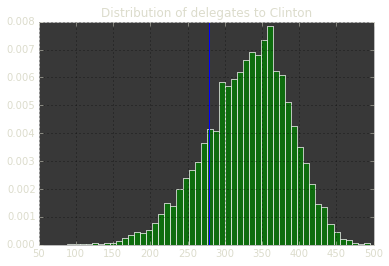

In [89]:
plt.title('Distribution of delegates to Clinton')
plt.hist(simulations, 50, normed=1, facecolor='green', alpha=0.75)
plt.axvline(x=279)


# Something doesn't add up. Where are the biases?

Our estimated 97% chance of a Clinton win is significantly higher than the PredictIt general election market (which has about 82¢ for Clinton shares as of 10-16-16). It is also much higher than Rothchild's [debiased aggregate](http://predictwise.com/). Are the general markets not bullish enough on Clinton, or are the state markets too bullish on Clinton?

Let's assume that the national election markets, and poll-based forecasts, are roughly correct. What would it mean for the state markets to undervalue a Clinton win? Well, let's take a look at those states where market prices have an estimated 20% to 50% chance of a Clinton win.

In [90]:
filter(lambda s: s['probability']<0.5 and s['probability']>0.2, states)

[{'abbreviation': 'GA', 'delegates': 16, 'probability': 0.28},
 {'abbreviation': 'AK', 'delegates': 3, 'probability': 0.2475},
 {'abbreviation': 'AZ', 'delegates': 11, 'probability': 0.45999999999999996},
 {'abbreviation': 'MO', 'delegates': 10, 'probability': 0.2025}]

Excluding Utah, which has a [non-negligable chance of a 3rd-party win](http://www.nytimes.com/2016/10/15/us/politics/evan-mcmullin-campaign-utah.html?_r=0), these other states may have overvalued Clinton shares.

To sanity check, let's replicate everything with Rothchild's de-biased, market-derived probabilities.

In [120]:
def predictwise_states ():
    table = json.loads(requests.get('http://table-cache1.predictwise.com/latest/table_1551.json').content)
    def predictwise_state (row):
        return {'name': row[0],
                'probability': float(int(row[2].split(' ')[0]))/100.0,
                'delegates': int(row[-1])}
    return map(predictwise_state, table['table'])

pw_states = predictwise_states()
pw_states

[{'delegates': 9, 'name': u'Alabama', 'probability': 0.01},
 {'delegates': 3, 'name': u'Alaska', 'probability': 0.13},
 {'delegates': 11, 'name': u'Arizona', 'probability': 0.45},
 {'delegates': 6, 'name': u'Arkansas', 'probability': 0.02},
 {'delegates': 55, 'name': u'California', 'probability': 1.0},
 {'delegates': 9, 'name': u'Colorado', 'probability': 0.96},
 {'delegates': 7, 'name': u'Connecticut', 'probability': 1.0},
 {'delegates': 3, 'name': u'Delaware', 'probability': 1.0},
 {'delegates': 3, 'name': u'District of Columbia', 'probability': 1.0},
 {'delegates': 29, 'name': u'Florida', 'probability': 0.9},
 {'delegates': 16, 'name': u'Georgia', 'probability': 0.16},
 {'delegates': 4, 'name': u'Hawaii', 'probability': 1.0},
 {'delegates': 4, 'name': u'Idaho', 'probability': 0.01},
 {'delegates': 20, 'name': u'Illinois', 'probability': 1.0},
 {'delegates': 11, 'name': u'Indiana', 'probability': 0.07},
 {'delegates': 6, 'name': u'Iowa', 'probability': 0.61},
 {'delegates': 6, 'name'

Now we get a 100% pro